# Correct PINNs Prediction with FEM and $\phi$-FEM

Maillage standard créé avec la levelset 

+Interpolation solution sur maillage surraffinée

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import os
import shutil

In [3]:
from scimba.equations.domain import SpaceTensor
from scar.problem.Case import *
from scar.equations.Poisson2D import *
from scar.utils import read_config,create_tree
from scar.equations.run_Poisson2D import *

from scar.solver.solver_fem import *
from scar.solver.solver_phifem import *
from scar.correction.correct_pred import *

Using device: cuda
cuda devices:        1
cuda current device: 0
cuda device name:    NVIDIA RTX 2000 Ada Generation Laptop GPU


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


torch loaded; device is cuda
torch loaded; device is cuda


## Define case

In [4]:
config = 1
casefile = "../../testcases/"+"lap_circle_1.json"

cas = Case(casefile)
problem_considered = cas.problem
pde_considered = cas.pde
form_considered = cas.form

type = 0 # help="0 - all ; 1 - add ; 2 - add IPP ; 3 - mult"

dir_name = "../../"+cas.dir_name
models_dir = dir_name+"models/"
config_filename = models_dir+"config_"+str(config)+".json"
corr_type = cas.corr_type
corr_dir = "../../"+cas.corr_dir_name
create_tree(corr_dir)
# don't show plots
plt.close()
plt.close()

bc_points.shape = (2000, 2), bc_normals.shape = (2000, 2)
>> load network /home/flecourtier/Bureau/Thèse/networks/EikonalLap2D/Circle/models/model_1.pth
jsbdbshd


In [5]:
form_trainer = cas.sd_function.form_trainer
phi_theta = cas.sd_function.eik_pinns

config_dict = read_config(config_filename)
trainer = run_Poisson2D(cas,config,config_dict)
u_theta = trainer.network
plt.close()

Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
>> load network /home/flecourtier/Bureau/Thèse/networks/Poisson2D/Circle/SDEikonalLap/ConstantForce/form_1/0.0/models/model_1.pth
jsbdbshd
network loaded


## Correction

In [6]:
mesh_dir = str(current / "networks" / "EikonalLap2D" / form_considered.__class__.__name__ / "meshes")+"/"
if os.path.exists(mesh_dir):
    shutil.rmtree(mesh_dir)

In [7]:
if trainer.pde.nb_parameters == 0:
    params = [[None,None,None]]
else:
    mu = torch.mean(trainer.pde.parameter_domain, axis=1)
    S,f,p = mu.numpy()
    params = [[S,f,p]]

nb_vert = 32
deg_corr = 8

### Avec FEM

In [8]:
solver = FEMSolver(nb_cell=nb_vert-1, params=params, cas=cas)

# get differents solutions
# analytical = problem_considered.analytical_sol
analytical = False
if analytical:
    u_ex = UexExpr(params[0], degree=10, domain=solver.mesh, pb_considered=solver.pb_considered)
else:
    mesh_ex,V_ex,u_ex = problem_considered.u_ref(form_trainer,mesh_dir)
    dx_ex = Measure("dx", domain=mesh_ex)

hmin =  0.001
hmax =  0.005
mmg2d_O3 -nr -hmin 0.001 -hmax 0.005 -hausd 0.0001 -ls -sol /tmp/tmp15lgsuax/Th.solb /tmp/tmp15lgsuax/Th.meshb
  -- MMG2D, Release 5.7.0 (Dec. 13, 2022) 
     Copyright (c) Bdx INP/CNRS/Inria/UPMC, 2004-
     Mar 12 2024 16:58:31

  -- INPUT DATA
  %% /tmp/tmp15lgsuax/Th.meshb OPENED
  %% /tmp/tmp15lgsuax/Th.solb OPENED
  -- DATA READING COMPLETED.     0.004s

  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
   MODULE MMG2D: 5.7.0 (Dec. 13, 2022)
  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
     git branch: master
     git commit: b8995360a4c5b894949c08b1bba90750a2062a7a
     git date:   2024-01-30 11:43:38 +0100


  -- MMG2DLS: INPUT DATA
  --  INPUT DATA COMPLETED.     0.000s

  -- PHASE 1 : ISOSURFACE DISCRETIZATION

  -- MESH QUALITY   20000
     BEST   0.866025  AVRG.   0.866025  WRST.   0.866025 (7)
     HISTOGRAMM:  100.00 % > 0.12
  *** Manifold implicit surface.
  -- PHASE 1 COMPLETED.     0.003s

  -- PHASE 2 : ANALY

discarding line.


Reading mesh from file


In [9]:
# V_test1 = FunctionSpace(solver.mesh, "CG", 1)
# V_test2 = FunctionSpace(solver.mesh, "CG", 5)

# f_test1 = Function(V_test1)
# f_test1.vector()[:] = 1.0

# f_test1_inter = interpolate(f_test1,V_test2)

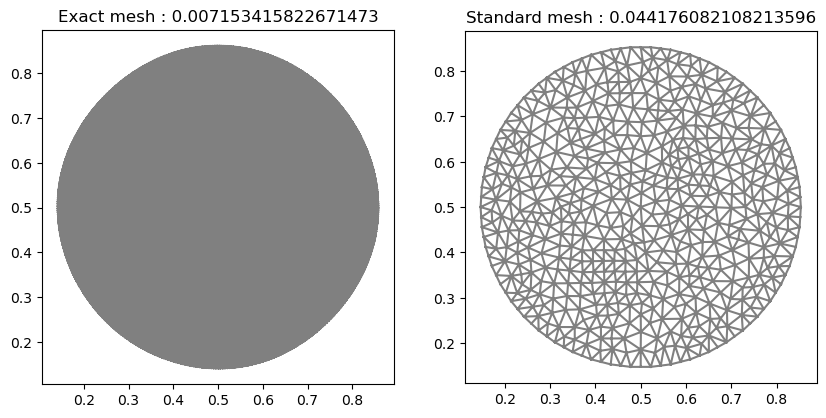

In [25]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plot(mesh_ex)
plt.title("Exact mesh : "+str(mesh_ex.hmax()))

plt.subplot(1,2,2)
plot(solver.mesh)
plt.title("Standard mesh : "+str(solver.mesh.hmax()))
plt.show()

Get u_PINNs on Vex
Get u_PINNs
Get u_Corr
Get u_FEM


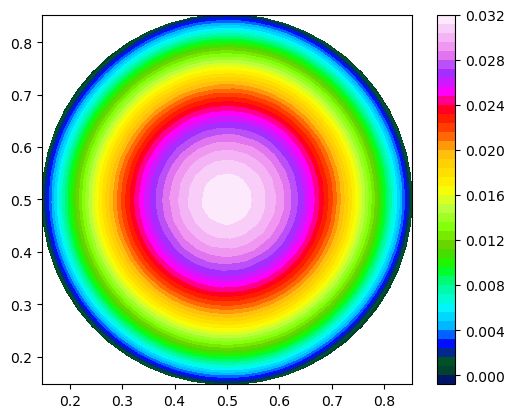

In [26]:
if analytical:
    u_PINNs, norm_L2_PINNs = get_u_PINNs(trainer,solver,deg_corr,get_error=True,analytical_sol=analytical)
    u_Corr,C,norm_L2_Corr = correct_pred(solver,u_PINNs,corr_type,analytical_sol=analytical)
    u_FEM,norm_L2_FEM = solver.fem(0,analytical_sol=analytical)
else:
    print("Get u_PINNs on Vex")
    
    XXYY = V_ex.tabulate_dof_coordinates()
    X_test,mu_test = create_test_sample(XXYY, trainer.pde.parameter_domain)

    pred = u_theta.setup_w_dict(X_test, mu_test)
    phi_tild = pred["w"][:,0].cpu().detach().numpy()
    u_PINNs_Vex = Function(V_ex)
    u_PINNs_Vex.vector()[:] = phi_tild.copy()
    norm_L2_PINNs = (assemble((((u_ex - u_PINNs_Vex)) ** 2) * dx_ex) ** (0.5)) / (assemble((((u_ex)) ** 2) * dx_ex) ** (0.5))
    
    print("Get u_PINNs")

    u_PINNs, _ = get_u_PINNs(trainer,solver,deg_corr,get_error=False,analytical_sol=analytical)
    
    print("Get u_Corr")

    u_Corr,C,_ = correct_pred(solver,u_PINNs,corr_type,get_error=False,analytical_sol=analytical)
    C_inter = interpolate(C, V_ex)
    # u_Corr_inter = project(u_Corr, solver.V)
    # u_Corr_inter = interpolate(u_Corr_inter, V_ex)
    u_Corr_inter = Function(V_ex)
    u_Corr_inter.vector()[:] = u_PINNs_Vex.vector().copy()[:] + C_inter.vector().copy()[:]
    norm_L2_Corr = (assemble((((u_ex - u_Corr_inter)) ** 2) * dx_ex) ** (0.5)) / (assemble((((u_ex)) ** 2) * dx_ex) ** (0.5))

    print("Get u_FEM")

    u_FEM,_ = solver.fem(0,get_error=False,analytical_sol=analytical)
    u_FEM_inter = interpolate(u_FEM, V_ex)
    norm_L2_FEM = (assemble((((u_ex - u_FEM_inter)) ** 2) * dx_ex) ** (0.5)) / (assemble((((u_ex)) ** 2) * dx_ex) ** (0.5))

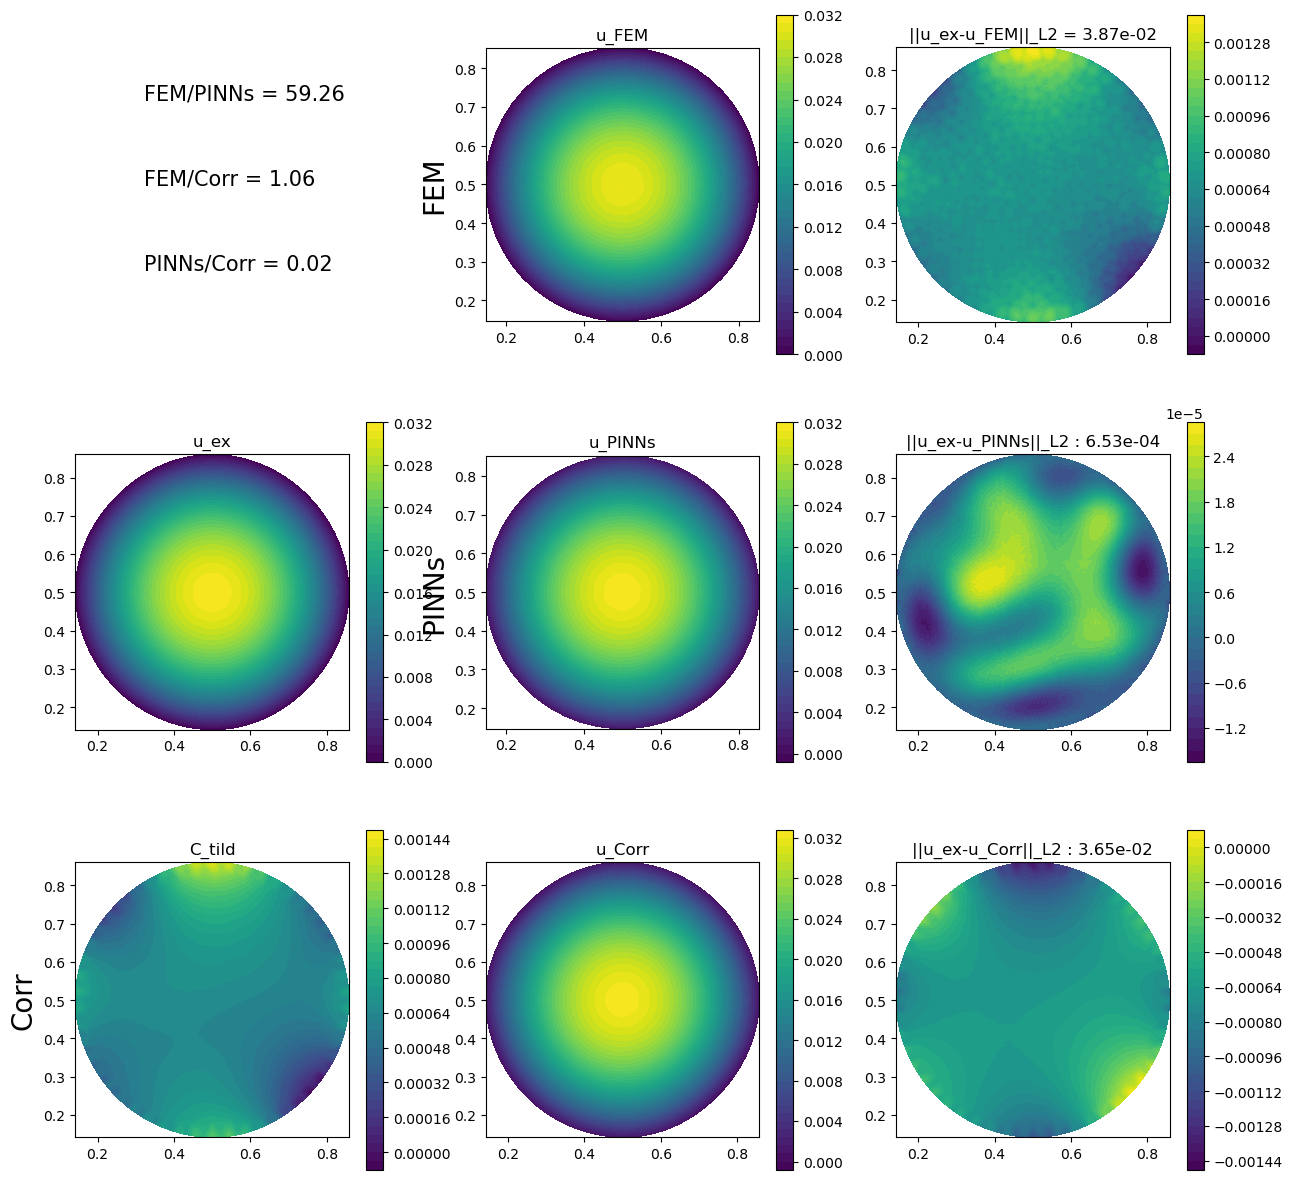

In [27]:
plt.figure(figsize=(15,15))

plt.subplot(3,3,1)

plt.text(0.2,0.75,"FEM/PINNs = {:.2f}".format(norm_L2_FEM/norm_L2_PINNs),fontsize=15)
plt.text(0.2,0.5,"FEM/Corr = {:.2f}".format(norm_L2_FEM/norm_L2_Corr),fontsize=15)
plt.text(0.2,0.25,"PINNs/Corr = {:.2f}".format(norm_L2_PINNs/norm_L2_Corr),fontsize=15)
plt.axis('off')

# FEM
plt.subplot(3,3,2)
c = plot(u_FEM, title="u_FEM")
plt.ylabel("FEM", fontsize=20)
plt.colorbar(c)

plt.subplot(3,3,3)
error = Function(V_ex)
error.vector()[:] = u_ex.vector().copy()[:] - u_FEM_inter.vector().copy()[:]
c = plot(error, title="||u_ex-u_FEM||_L2 = {:.2e}".format(norm_L2_FEM))
plt.colorbar(c)

plt.subplot(3,3,4)
c = plot(u_ex, title="u_ex")
plt.colorbar(c)

plt.subplot(3,3,5)
c = plot(u_PINNs, title="u_PINNs")
plt.ylabel("PINNs", fontsize=20)
plt.colorbar(c)

plt.subplot(3,3,6)
error = Function(V_ex)
error.vector()[:] = u_ex.vector().copy()[:] - u_PINNs_Vex.vector().copy()[:]
# error = project(error,project_on)
c = plot(error, title="||u_ex-u_PINNs||_L2 : {:.2e}".format(norm_L2_PINNs))
plt.colorbar(c)

# Corr
plt.subplot(3,3,7)
c = plot(C_inter, title="C_tild")
plt.ylabel("Corr", fontsize=20)
plt.colorbar(c) 

plt.subplot(3,3,8)
c = plot(u_Corr_inter, title="u_Corr")
plt.colorbar(c)

plt.subplot(3,3,9)
error = Function(V_ex)
error.vector()[:] = u_ex.vector().copy()[:] - u_Corr_inter.vector().copy()[:]
# error = u_ex-project(u_Corr,project_on)
c = plot(error, title="||u_ex-u_Corr||_L2 : {:.2e}".format(norm_L2_Corr))
plt.colorbar(c)

FEM_dir = corr_dir+"FEM"+"/"
if not os.path.exists(FEM_dir):
    os.makedirs(FEM_dir)
plt.savefig(FEM_dir+"corr_"+"FEM"+"_"+str(config)+".png")

### Avec PhiFEM

In [13]:
solver = PhiFemSolver(nb_cell=nb_vert-1, params=params, cas=cas)

# get differents solutions
analytical = problem_considered.analytical_sol
if analytical:
    u_ex = UexExpr(params[0], degree=10, domain=solver.mesh, pb_considered=solver.pb_considered)
    u_PINNs, norm_L2_PINNs = get_u_PINNs(trainer,solver,deg_corr,get_error=True,analytical_sol=analytical)
    u_Corr,C,norm_L2_Corr = correct_pred(solver,u_PINNs,corr_type,analytical_sol=analytical)
    u_FEM,norm_L2_FEM = solver.fem(0,analytical_sol=analytical)
else:
    mesh_dir = dir_name + "meshes/"
    mesh_ex,V_ex,u_ex = problem_considered.u_ref(form_trainer,mesh_dir)

    # print("Get u_PINNs")

    u_PINNs, _ = get_u_PINNs(trainer,solver,deg_corr,get_error=False,analytical_sol=analytical)
    # u_PINNs_inter = interpolate(u_PINNs_inter, V_ex)
    norm_L2_PINNs = (assemble((((u_ex - u_PINNs)) ** 2) * solver.dx) ** (0.5)) / (assemble((((u_ex)) ** 2) * solver.dx) ** (0.5))
    
    print("Get u_Corr")

    u_Corr,C,_ = correct_pred(solver,u_PINNs,corr_type,get_error=False,analytical_sol=analytical)
    u_Corr_inter = project(u_Corr, solver.V)
    u_Corr_inter = interpolate(u_Corr_inter, V_ex)
    norm_L2_Corr = (assemble((((u_ex - u_Corr_inter)) ** 2) * solver.dx) ** (0.5)) / (assemble((((u_ex)) ** 2) * solver.dx) ** (0.5))

    print("Get u_FEM")

    u_FEM,_ = solver.fem(0,get_error=False,analytical_sol=analytical)
    u_FEM_inter = interpolate(u_FEM, V_ex)
    norm_L2_FEM = (assemble((((u_ex - u_FEM_inter)) ** 2) * solver.dx) ** (0.5)) / (assemble((((u_ex)) ** 2) * solver.dx) ** (0.5))

# # get differents solutions
# analytical = problem_considered.analytical_sol
# if analytical:
#     u_ex = UexExpr(params[0], degree=10, domain=solver.mesh, pb_considered=solver.pb_considered)
# else:
#     u_ex = problem_considered.u_ref()
# u_PINNs, norm_L2_PINNs = get_u_PINNs(trainer,solver,deg_corr, get_error=True,analytical_sol=analytical)
# print("u_PINNs : ",norm_L2_PINNs)
# u_Corr,C,norm_L2_Corr = correct_pred(solver,u_PINNs,corr_type,analytical_sol=analytical)
# print("u_Corr : ",norm_L2_Corr)
# u_FEM,norm_L2_FEM = solver.fem(0,analytical_sol=analytical)
# print("u_FEM : ",norm_L2_FEM)

TypeError: 'TrainerEikonal' object is not callable

Building point search tree to accelerate distance queries.
Computed bounding box tree with 14569 nodes for 7285 points.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


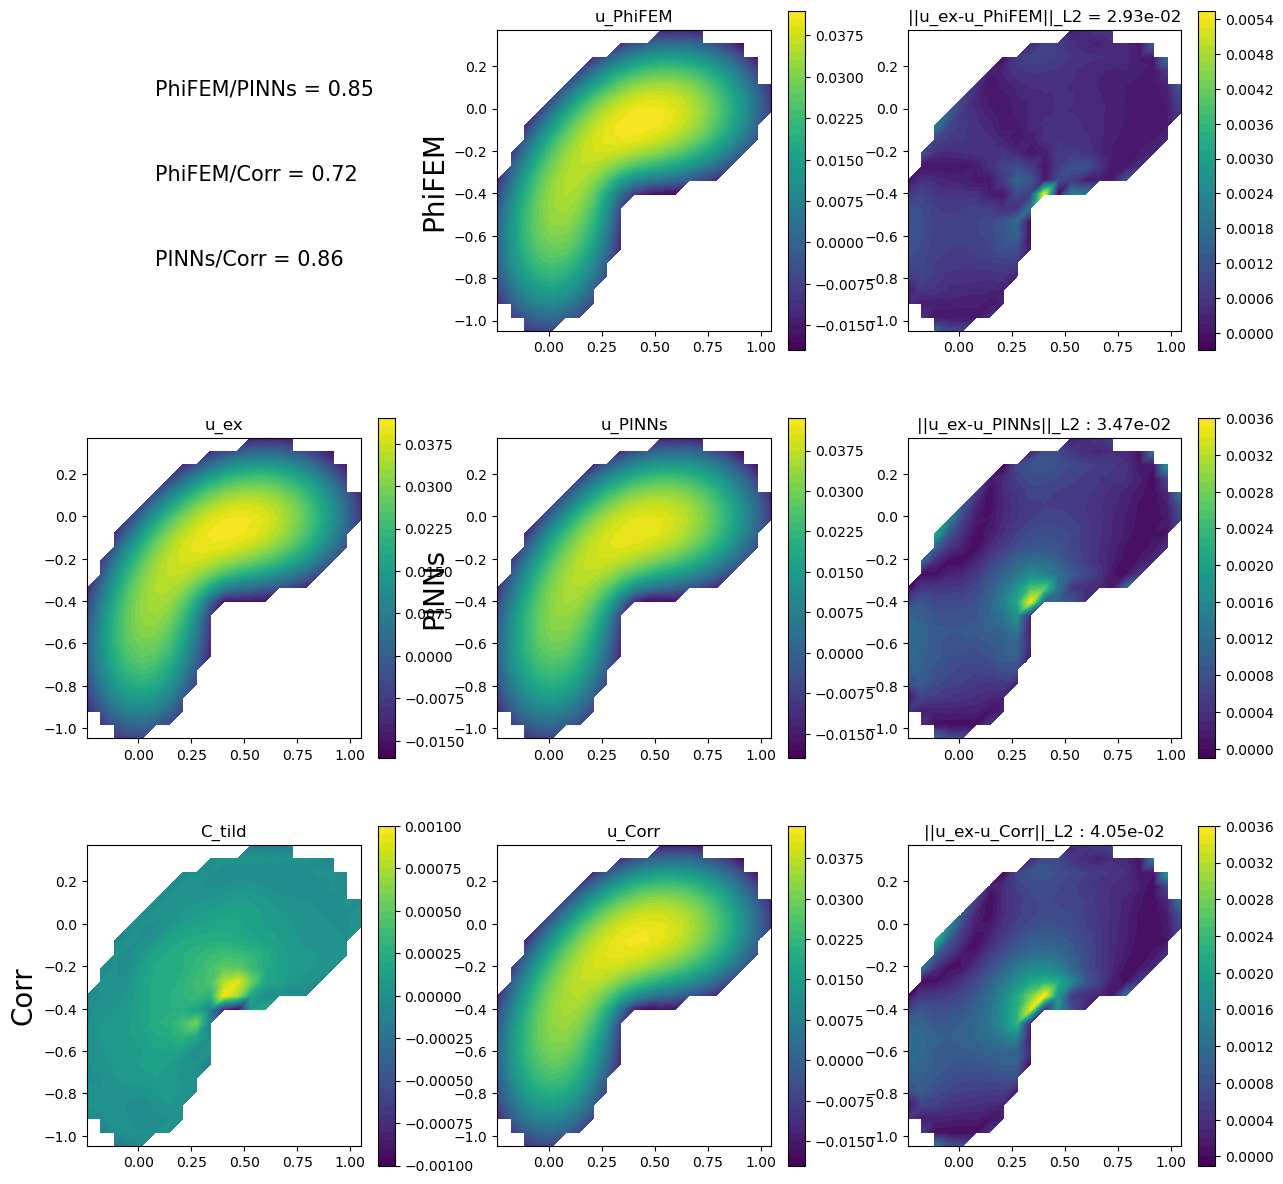

In [ ]:
# plot
u_ex = project(u_ex, solver.V)

solutions = [u_PINNs,u_Corr,u_FEM]
normes = [norm_L2_PINNs,norm_L2_Corr,norm_L2_FEM]

plot_sol(corr_dir,config,"PhiFEM",u_ex,C,solutions,normes,solver.V)

Projection sur $\Omega$ :

Building point search tree to accelerate distance queries.
Computed bounding box tree with 973 nodes for 487 points.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


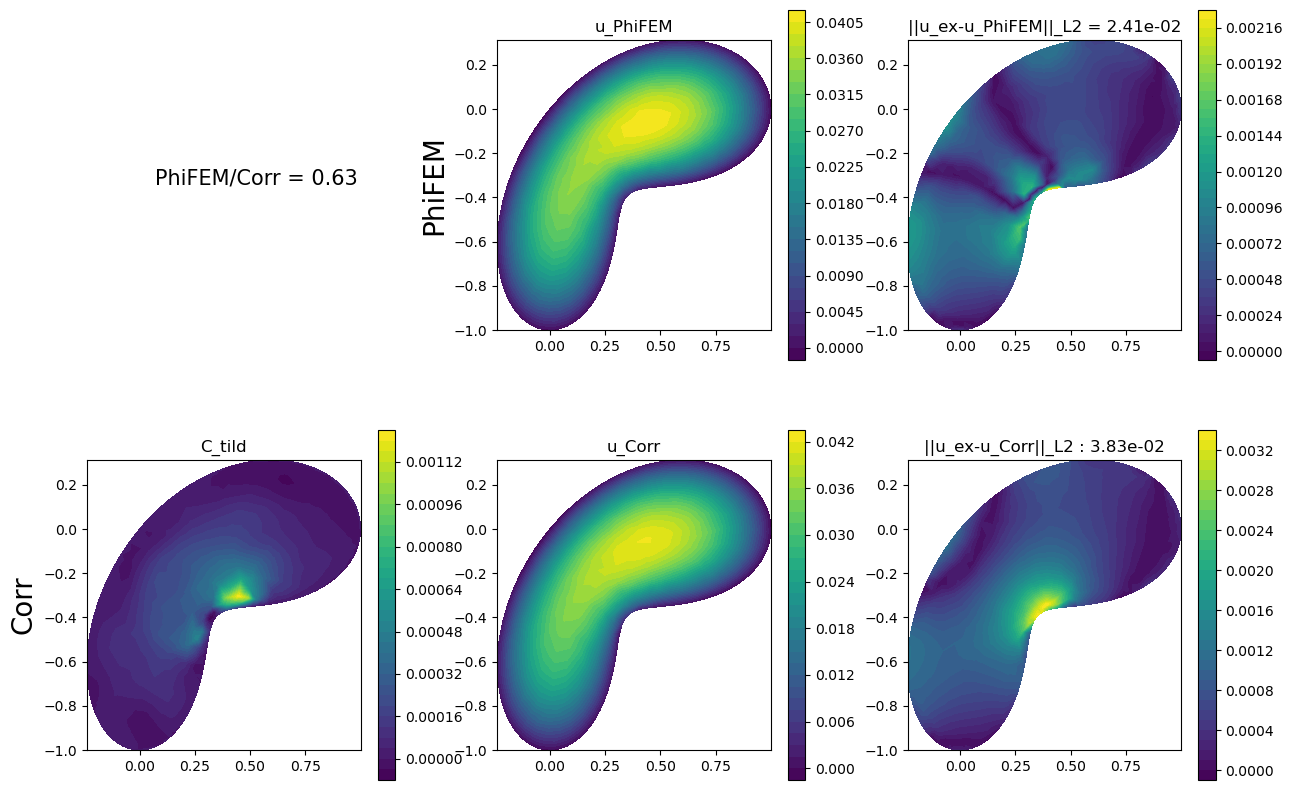

In [ ]:
# project u_ex on Omega
u_ex_Omega = project(u_ex, solver.V_ex)

# project u_Corr on Omega
u_Corr_ = project(u_Corr, solver.V)
u_Corr_Omega = project(u_Corr_, solver.V_ex)    
norm_L2_Corr_Omega = (assemble((((u_ex_Omega - u_Corr_Omega)) ** 2) * solver.dx_ex) ** (0.5)) / (assemble((((u_ex_Omega)) ** 2) * solver.dx_ex) ** (0.5))

# project u_FEM on Omega
u_FEM_ = project(u_FEM, solver.V)
u_FEM_Omega = project(u_FEM_, solver.V_ex)

norm_L2_FEM_Omega = (assemble((((u_ex_Omega - u_FEM_Omega)) ** 2) * solver.dx_ex) ** (0.5)) / (assemble((((u_ex_Omega)) ** 2) * solver.dx_ex) ** (0.5))


#####
# Plot !
#####

solutions = [u_Corr_Omega,u_FEM_Omega]
normes = [norm_L2_Corr_Omega,norm_L2_FEM_Omega]
# plot_sol(corr_type,"PhiFEM",u_ex_Omega,solutions,normes,solver.V_ex,project_on_Omega=True)
plot_sol(corr_dir,config,"PhiFEM",u_ex_Omega,C,solutions,normes,solver.V_ex,project_on_Omega=True)